In [1]:
from util import get_dummies, detect_str_columns,model_testRF,results_summary_to_dataframe,plot_confusion_matrix,logistic_model,logistic_importance,logistic_conf,model_profit_fun,model_profit_newdata_fun
from util import profit_linechart, profit_linechart_all
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
# ----設定繪圖-------
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import os
import platform
# 讀取電商資料
data = pd.read_csv('contract.csv',encoding='cp950')

In [2]:
data.head()

,Prod_output_num,locations,gender,age,click_on_prod,balance,registry_to_use_time,credit_card_paid,active_member,estimated_salary,buy,UID
0,619,Taipei,Female,42,2,0.00,4,1,0,101348.88,1,0
1,608,Tainan,Female,41,1,83807.86,4,0,0,112542.58,0,1
2,502,Taipei,Female,42,8,159660.80,2,1,1,113931.57,1,2
3,699,Taipei,Female,39,1,0.00,3,0,1,93826.63,0,3
4,850,Tainan,Female,43,2,125510.82,4,1,0,79084.10,0,4


不購買 79.63 % of the dataset
購買 20.37 % of the dataset


Text(0.5, 1.0, 'purchase decision \n (0:no vs 1:yes )')

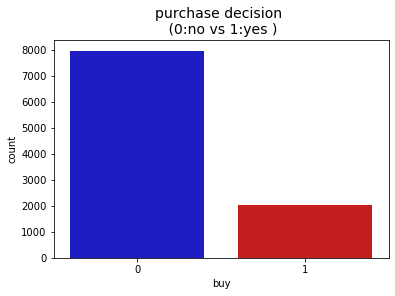

In [3]:
# ------------變數視覺化------------
# buy
print('不購買', round(data['buy'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('購買', round(data['buy'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

# 看看y變數的分佈
colors = ["#0101DF", "#DF0101"]
sns.countplot('buy', data=data, palette=colors)
plt.title('purchase decision \n (0:no vs 1:yes )', fontsize=14)

In [4]:
# 使用-獨熱編碼
data=pd.concat([data.drop(["locations","gender"],axis=1),pd.get_dummies(data[["locations","gender"]])],axis=1)
data.head()

,Prod_output_num,age,click_on_prod,balance,registry_to_use_time,credit_card_paid,active_member,estimated_salary,buy,UID,locations_Taichung,locations_Tainan,locations_Taipei,gender_Female,gender_Male
0,619,42,2,0.00,4,1,0,101348.88,1,0,0,0,1,1,0
1,608,41,1,83807.86,4,0,0,112542.58,0,1,0,1,0,1,0
2,502,42,8,159660.80,2,1,1,113931.57,1,2,0,0,1,1,0
3,699,39,1,0.00,3,0,1,93826.63,0,3,0,0,1,1,0
4,850,43,2,125510.82,4,1,0,79084.10,0,4,0,1,0,1,0


In [5]:
X =data.drop(columns=['buy'])
y =data['buy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

# 來看看各自的維度
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# ------------ 資料處理與轉換 - 將UID拿出來 ------------
# 保留UID
train_uid = X_train['UID']
test_uid = X_test['UID']

(8000, 14)
(8000,)
(2000, 14)
(2000,)


In [6]:
del X_train['UID']
del X_test['UID']

In [7]:
xgb_model = XGBClassifier(n_estimators=100 ,random_state = 0, nthread = 8, learning_rate=0.5)
# 進行訓練
model_xgb = xgb_model.fit(X_train, y_train, verbose=True)
# 進行預測
xgb_pred = model_xgb.predict(X_test)
# 預測機率
xgb_pred_prob = model_xgb.predict_proba(X_test)
xgb_conf =confusion_matrix(y_test, xgb_pred)

In [8]:
# -------------- 製作顧客產品推薦名單 -------------------
XGBClassifier_test_df=pd.DataFrame(y_test.values ,columns =['客戶對A商品【實際】購買狀態'])
XGBClassifier_test_df['客戶對A商品【預測】購買機率'] = xgb_pred_prob[:,1]
test_uid = test_uid.reset_index().drop(columns = ['index'])

In [9]:
XGBClassifier_test_df=pd.concat([test_uid,XGBClassifier_test_df],axis=1)
XGBClassifier_test_df=XGBClassifier_test_df.sort_values("客戶對A商品【預測】購買機率",ascending=False).set_index("UID")
XGBClassifier_test_df.head(10)

,客戶對A商品【實際】購買狀態,客戶對A商品【預測】購買機率
UID,,
2872,1,0.998977
555,1,0.998776
2092,1,0.998482
3152,1,0.998132
2154,1,0.998009
7257,1,0.997992
4166,1,0.997404
9323,1,0.997297
7457,1,0.996950


In [10]:
print(confusion_matrix(y_test,xgb_pred))
print(accuracy_score(y_test,xgb_pred))

[[1499   96]
 [ 192  213]]
0.856


In [13]:
print(xgb_conf[1,:]) #實際購買人數

[192 213]


################ summary ################ 
[[1499   96]
 [ 192  213]]
Training Accuracy = 0.899
Test Accuracy = 0.856


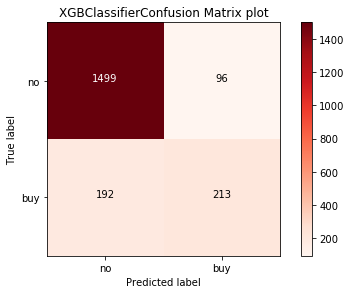

In [12]:
model_testRF( xgb_model, X_train,y_train,X_test,y_test, plot_name = 'XGBClassifier')

In [14]:
# -------------- 利潤評估模型 -------------------

# 預測出來了，感覺很厲害! 但… So what? 真的有【效果】？
# 要挑選什麼模型？

'''
1.獲利最佳化模型
2.閾值折線圖
'''

# 設定參數
sales_price = 3500
marketing_expense = 300
product_cost = 1650

In [15]:
all_profit = sales_price*xgb_conf[1,:].sum() - product_cost* xgb_conf[1,:].sum()- marketing_expense *  xgb_conf.sum()

all_df = pd.DataFrame({
        '項目' : ['單品價格', '單品營業成本', '單品行銷費用', '利潤'],
        '金額' : [sales_price,product_cost, marketing_expense, '-'],
        '目標對象' : [xgb_conf[1,::].sum(), xgb_conf[1,::].sum(), xgb_conf.sum(), '-'],
        '小計' : [sales_price*xgb_conf[1,::].sum(), product_cost* xgb_conf[1,::].sum(), marketing_expense *  xgb_conf.sum(),all_profit  ],
        })
all_df

,項目,金額,目標對象,小計
0,單品價格,3500,405,1417500
1,單品營業成本,1650,405,668250
2,單品行銷費用,300,2000,600000
3,利潤,-,-,149250


In [18]:
import pickle
def model_profit_fun(clf, X_train,y_train,X_test,y_test,sales_price = 3500,
                    marketing_expense = 300,
                    product_cost = 1750,
                    plot_name = 'logistic_regression') :
    
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    y_test_df=pd.DataFrame(y_test)
    y_test_df[plot_name+'_pred'] = y_pred_prob
    
    y_test_df.columns = ['buy', plot_name+'_pred']
    
    #Confusion Matrix
    conf_logist = confusion_matrix(y_test, y_pred)
    
    # 畫conf matrix
    plot_confusion_matrix(conf_logist, ['no','buy'],
                          title=plot_name+"Confusion Matrix plot", cmap=plt.cm.Reds)#, cmap=plt.cm.Reds
    
    
    # model_profit 
    model_profit = sales_price * conf_logist[1,1] - conf_logist[:,1].sum() * marketing_expense - product_cost * conf_logist[1,1]
    
    model_profit_df = pd.DataFrame({
            '項目' : ['單品價格', '單品營業成本', '單品行銷費用', '利潤'],
            '金額' : [sales_price,product_cost, marketing_expense, '-'],
            '目標對象' : [conf_logist[1,1],conf_logist[1,1], conf_logist[:,1].sum(), '-'],
            '小計' : [sales_price* conf_logist[1,1], product_cost* conf_logist[1,1], marketing_expense * conf_logist[:,1].sum(),model_profit],
            })
    
    
    # all_profit 
    all_profit = sales_price*conf_logist[1,:].sum() - product_cost* conf_logist[1,:].sum()- marketing_expense *  conf_logist.sum()
    
    all_df = pd.DataFrame({
            '項目' : ['單品價格', '單品營業成本', '單品行銷費用', '利潤'],
            '金額' : [sales_price,product_cost, marketing_expense, '-'],
            '目標對象' : [conf_logist[1,:].sum(), conf_logist[1,:].sum(), conf_logist.sum(), '-'],
            '小計' : [sales_price*conf_logist[1,:].sum(), product_cost* conf_logist[1,:].sum(), marketing_expense *  conf_logist.sum(),all_profit],
            })

    # -------single model summary--------
    
    # 創造docx
#    doc = Document()
    
    # save the doc

    print( "################ summary ################ ")
    
    print(confusion_matrix(y_test, y_pred))
    print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
    print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
    
    # profit comparison
    if model_profit - all_profit > 0 :
        print( '------------------模型相對全市場行銷來說【賺錢】------------------' )
        print( '模型比全市場行銷賺 $' + str(model_profit - all_profit) )
        
#        
#        if all_profit<0:
#            all_profit2 = model_profit - all_profit
#        else:
#            print( '比較全市場行銷來說，淨利增加' + str( round(model_profit / all_profit, 3) ) + '倍')
        
    else:
        print( '------------------模型相對全市場行銷來說【賠錢】------------------' )
        print( '模型比全市場行銷損失 $' + str(model_profit - all_profit) )
        print( '比較全市場行銷來說，淨利減少' + str( round(model_profit / all_profit, 3) ) + '倍')
        
    print( '------------------全市場行銷利潤矩陣------------------' )
    print(all_df)
    all_df.to_csv(plot_name+'全市場行銷利潤矩陣.csv')
    print('全市場行銷利潤矩陣.csv saved')
    
    
    print( '------------------' +plot_name+ '模型行銷利潤矩陣------------------' )
    print(model_profit_df)
    model_profit_df.to_csv(plot_name+'模型行銷利潤矩陣.csv')
    print('模型行銷利潤矩陣.csv saved')
    
    # 儲存模型
    pickle.dump(model, open(plot_name+"_model.dat", "wb"))
    
    # 顧客產品推薦名單
    y_test_df = y_test_df.sort_values([plot_name+'_pred'], ascending = False)
    y_test_df.to_csv(plot_name+'顧客產品推薦名單.csv')
    
    return all_df, model_profit_df,  y_test_df

C:\Users\POPO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


################ summary ################ 
[[1544   51]
 [ 377   28]]
Training Accuracy = 0.788
Test Accuracy = 0.786
------------------模型相對全市場行銷來說【賠錢】------------------
模型比全市場行銷損失 $-121150
比較全市場行銷來說，淨利減少0.188倍
------------------全市場行銷利潤矩陣------------------
       項目    金額  目標對象       小計
0    單品價格  3500   405  1417500
1  單品營業成本  1650   405   668250
2  單品行銷費用   300  2000   600000
3      利潤     -     -   149250
全市場行銷利潤矩陣.csv saved
------------------LogisticRegression模型行銷利潤矩陣------------------
       項目    金額 目標對象     小計
0    單品價格  3500   28  98000
1  單品營業成本  1650   28  46200
2  單品行銷費用   300   79  23700
3      利潤     -    -  28100
模型行銷利潤矩陣.csv saved


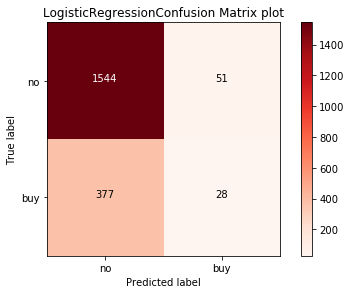

In [17]:
'''
功能：針對clf(classifier)設定的模型進行訓練，並且跑出利潤模型總表與顧客產品推薦名單
all_df : 全市場利潤表
profit_df : 預測模型利潤表
LR_y_test_df ：顧客產品推薦名單 
'''

LR_all_df, LR_model_profit_df, LR_y_test_df = model_profit_fun(
                                                    clf = LogisticRegression(),
                                                    X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test,
                                                    sales_price = 3500,
                                                    marketing_expense = 300,
                                                    product_cost = 1650,
                                                    plot_name = 'LogisticRegression')

In [28]:
def profit_linechart(y_test_df,sales_price = 3500,marketing_expense = 300,product_cost = 1750,plot_name = 'logistic_regression' ):
    profit_line = []
    for i in np.arange(0,1,0.01):
        
        # set threshold
        y_test_df['pred_yn']= np.where(y_test_df[y_test_df.columns[1]]>=i, 1,0)    
        
        
        conf_logist = confusion_matrix(y_test_df['buy'], y_test_df['pred_yn'])
        
        # model_profit 
        model_profit = sales_price * conf_logist[1,1] - conf_logist[:,1].sum() * marketing_expense - product_cost * conf_logist[1,1]
        
        
        # all_profit 
        all_profit = sales_price*conf_logist[1,:].sum() - product_cost* conf_logist[1,:].sum()- marketing_expense *  conf_logist.sum()
        
        # 將所有threshold append在一起
        profit_line.append([i,model_profit, all_profit])
    
    profit_line = pd.DataFrame(profit_line, columns= ['閥值', plot_name, '全市場'])
    # draw
    X_max = profit_line[profit_line[plot_name] ==profit_line[plot_name].max()]['閥值']
    Y_max =  profit_line[plot_name].max()
    profit_line = profit_line.rename( columns= {'閥值': 'threshold', '全市場' : 'all_market'})
    profit_line.plot.line(x='threshold', y=[plot_name,'all_market'],figsize=(15,10))
    plt.scatter(X_max,Y_max, c='red', marker='o',alpha=0.5)
    plt.text(X_max-0.005, Y_max+10000, plot_name+' best profit$ ' + str(Y_max ) + ', threshold='+  str(X_max.values[0]))
    plt.ylabel('expected profit')
    plt.savefig(plot_name+'_預期獲利最佳化模型與閥值折線圖.png', dpi=300)
    plt.show()

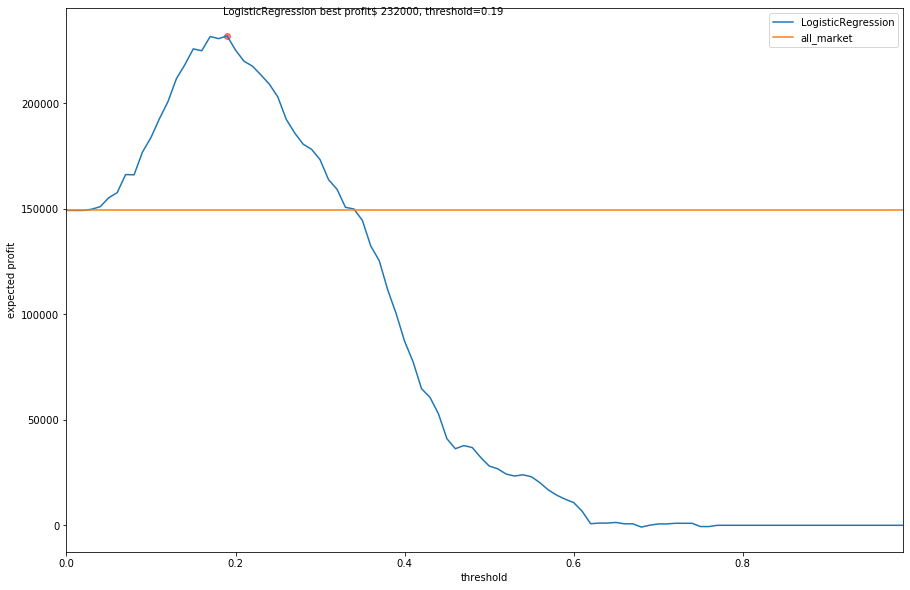

In [29]:
profit_linechart(
        y_test_df=LR_y_test_df,
                    sales_price = 3500,
                    marketing_expense = 300,
                    product_cost = 1650,
                    plot_name = 'LogisticRegression')

################ summary ################ 
[[1528   67]
 [ 197  208]]
Training Accuracy = 1.000
Test Accuracy = 0.868
------------------模型相對全市場行銷來說【賺錢】------------------
模型比全市場行銷賺 $153050
------------------全市場行銷利潤矩陣------------------
       項目    金額  目標對象       小計
0    單品價格  3500   405  1417500
1  單品營業成本  1650   405   668250
2  單品行銷費用   300  2000   600000
3      利潤     -     -   149250
全市場行銷利潤矩陣.csv saved
------------------Random_Forest模型行銷利潤矩陣------------------
       項目    金額 目標對象      小計
0    單品價格  3500  208  728000
1  單品營業成本  1650  208  343200
2  單品行銷費用   300  275   82500
3      利潤     -    -  302300
模型行銷利潤矩陣.csv saved


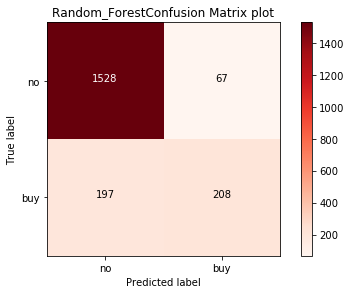

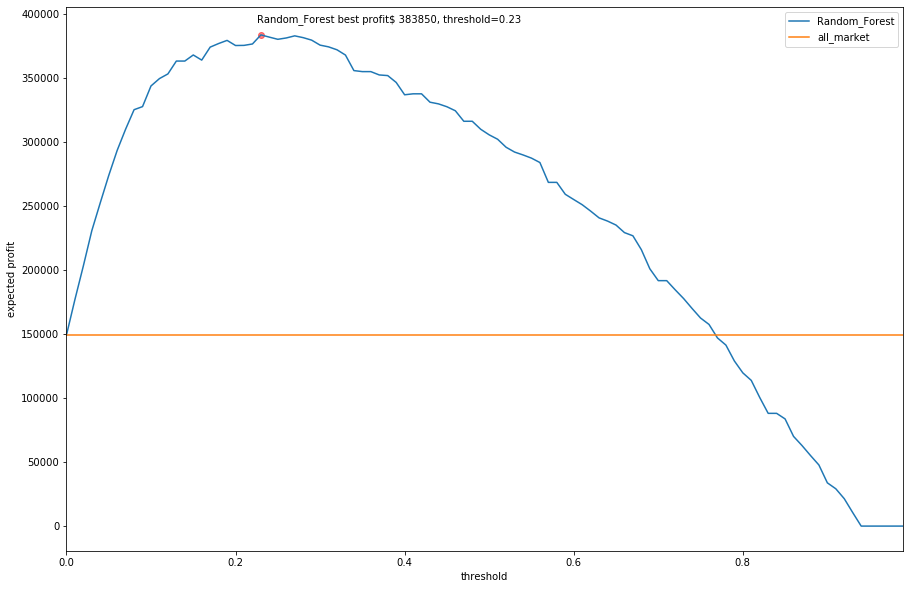

In [30]:
RF_all_df,RF_model_profit_df ,RF_y_test_df = model_profit_fun(
                                                    clf = RandomForestClassifier(n_estimators = 100, random_state = 0),
                                                    X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test,
                                                    sales_price = 3500,
                                                    marketing_expense = 300,
                                                    product_cost = 1650,
                                                    plot_name = 'Random_Forest')
profit_linechart(
        y_test_df=RF_y_test_df,
                    sales_price = 3500,
                    marketing_expense = 300,
                    product_cost = 1650,
                    plot_name ='Random_Forest')

################ summary ################ 
[[1522   73]
 [ 192  213]]
Training Accuracy = 0.885
Test Accuracy = 0.868
------------------模型相對全市場行銷來說【賺錢】------------------
模型比全市場行銷賺 $159000
------------------全市場行銷利潤矩陣------------------
       項目    金額  目標對象       小計
0    單品價格  3500   405  1417500
1  單品營業成本  1650   405   668250
2  單品行銷費用   300  2000   600000
3      利潤     -     -   149250
全市場行銷利潤矩陣.csv saved
------------------xgboost模型行銷利潤矩陣------------------
       項目    金額 目標對象      小計
0    單品價格  3500  213  745500
1  單品營業成本  1650  213  351450
2  單品行銷費用   300  286   85800
3      利潤     -    -  308250
模型行銷利潤矩陣.csv saved


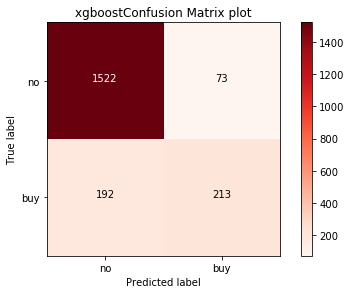

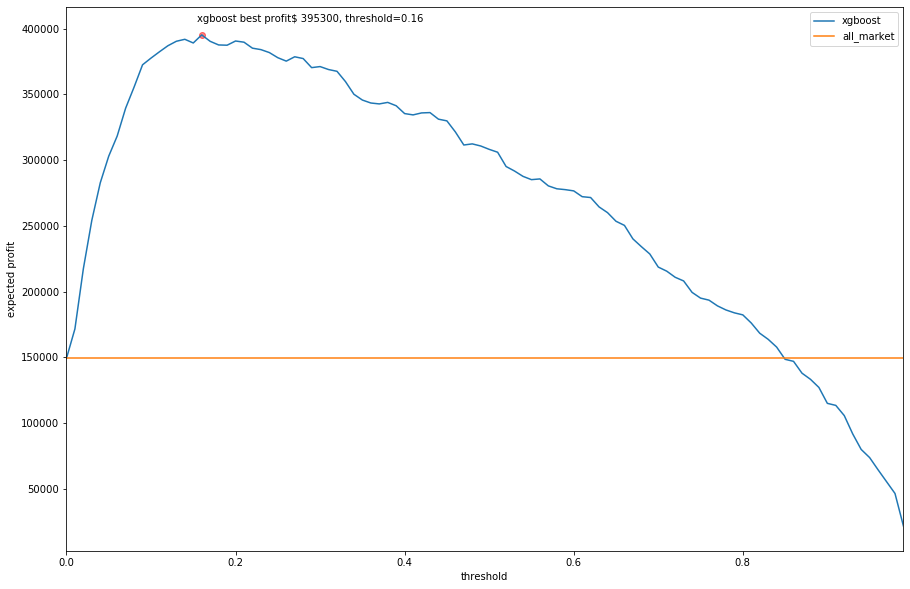

In [31]:
xgboost_all_df,xgboost_model_profit_df,xgboost_y_test_df = model_profit_fun(
                                                    clf = XGBClassifier(n_estimators=300 ,random_state = 0,nthread = 8),
                                                    X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test,
                                                    sales_price = 3500,
                                                    marketing_expense = 300,
                                                    product_cost = 1650,
                                                    plot_name ='xgboost' )
profit_linechart(
        y_test_df=xgboost_y_test_df,
                    sales_price = 3500,
                    marketing_expense = 300,
                    product_cost = 1650,
                    plot_name ='xgboost')

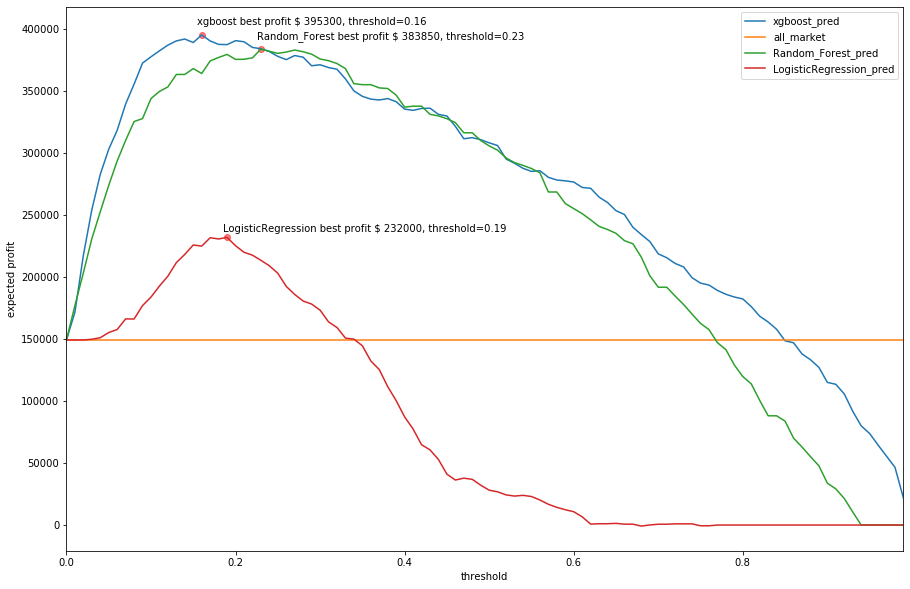

In [32]:
profit_linechart_all(y_test_df= [xgboost_y_test_df, RF_y_test_df, LR_y_test_df] ,
                    sales_price = 3500,
                    marketing_expense = 300,
                    product_cost = 1650)